In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Import libraries
import os
import re
import string

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

In [2]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tweet-sentiment-extraction/train.csv
/kaggle/input/tweet-sentiment-extraction/test.csv
/kaggle/input/tweet-sentiment-extraction/sample_submission.csv
/kaggle/input/tf-roberta/vocab-roberta-base.json
/kaggle/input/tf-roberta/pretrained-roberta-base.h5
/kaggle/input/tf-roberta/config-roberta-base.json
/kaggle/input/tf-roberta/merges-roberta-base.txt


# Exploratory Data Analysis

In [3]:
train = pd.read_csv("/kaggle/input/tweet-sentiment-extraction/train.csv")
test = pd.read_csv("/kaggle/input/tweet-sentiment-extraction/test.csv")

In [4]:
print("Training set has {} data points".format(len(train)))
print("Testing set has {} data points".format(len(test)))

Training set has 27481 data points
Testing set has 3534 data points


In [5]:
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [6]:
test.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [7]:
train = train.dropna().reset_index(drop=True)

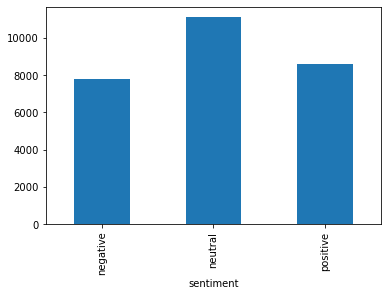

In [8]:
# plot the total count of sentiments in training data
train.groupby('sentiment').count()['textID'].plot(kind='bar')

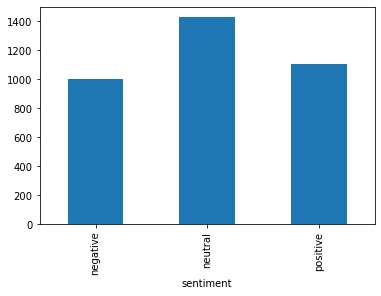

In [9]:
# plot the total count of sentiments in testing data
test.groupby('sentiment').count()['textID'].plot(kind='bar')

We can observe from the above plots that both the training and test data have the same distribution. This allows us a lot of flexibility in our choice of model algorithm.

The proportion of neutral sentiments is little higher than that of positive and negative sentiments. This should not affect the algorithm, but I can make use of Stratified cross-validation to combat this.

In [10]:
# Finding out if 'selected_text' is same as 'text'
train['st_eq_text'] = train.apply(
    lambda x: 'same' if x.text.replace(x.selected_text, '') == '' else 'different', 
    axis=1)

We could see in the training sample that some instances of 'selected_text' are same as 'text'. Let's do an analysis of such tweets where the selected_text is the tweet itself by different sentiment types. 

In [11]:
df = train.groupby(
    ['sentiment', 'st_eq_text']).size().reset_index()
df = df.rename(columns={0:'same_as_tweet'})
df

,sentiment,st_eq_text,same_as_tweet
0,negative,different,6984
1,negative,same,797
2,neutral,different,5187
3,neutral,same,5930
4,positive,different,8026
5,positive,same,556


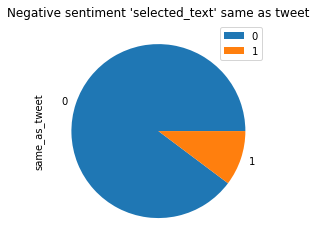

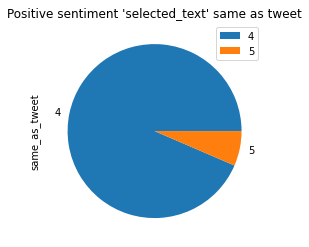

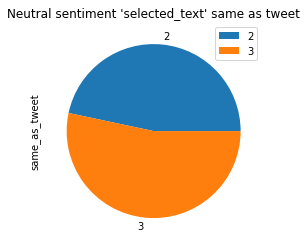

In [12]:
df[df.sentiment=='negative'].plot.pie(
    y='same_as_tweet',
    title="Negative sentiment 'selected_text' same as tweet")

df[df.sentiment=='positive'].plot.pie(
    y='same_as_tweet',
    title="Positive sentiment 'selected_text' same as tweet")

df[df.sentiment=='neutral'].plot.pie(
    y='same_as_tweet',
    title="Neutral sentiment 'selected_text' same as tweet")

We can see in the above plots, that for the Neutral sentiment, more than 50% of 'selected_text' is same as 'text' (tweet)